### LLM

In [1]:
import os
import json
import re
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
from langchain_groq import ChatGroq

# llm = ChatGroq(model="qwen/qwen3-32b")
llm = ChatGroq(model="openai/gpt-oss-120b")
# llm.invoke("Hello, world!",reasoning_format="hidden")   

In [2]:
from typing import Annotated,List ,Optional
import operator 
from typing_extensions import Literal,TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage,SystemMessage 
from IPython.display import display,Image,Markdown
from langgraph.types import Send 
from tavily import TavilyClient
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

Utils

In [3]:
def get_content_from_json(json_data):
    json_str = re.search(r"```json\n(.*?)\n```", json_data.content, re.DOTALL).group(1)
    data = json.loads(json_str)
    return data

### TOOLS

In [4]:
# methods = "Transfer learning ,finetuning of cnn, support vector machine, random forest classifier,linear dicriminant analysis,prinicpal compnent analysis,independent component analysis,genetic alforithm,binary bat optimisation,binary particle swarm optimisation "

In [5]:
# methods_list = methods.split(',')
# methods_list

In [6]:
def WikiSearchContent(query):
    api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=1000)
    wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
    result = wiki.run(query)
    llm = ChatGroq(model="qwen/qwen3-32b")
    prompt = [
    SystemMessage(
        content=f"""You are good content writer and also a researcher.
        Follow the below instructions while generatin response for the topic: {query}
         **Instructions:**
        - Each method should include:
            - A Title heading (Bold)
            • A detailed summary (~500 words)
            • Relevant equations
            • A separator (e.g., "---") at the end
        \n\n
        if found relevant use the below extra content
        \n\n
        {result}
        
        Note: Dont include any Subheadings!!!! just the content as paragraph is needed."""
    )
]
    res = llm.invoke(prompt,reasoning_format="hidden")
    return res.content

In [7]:
# api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=3,doc_content_chars_max=2500)
# wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
# wiki.name

In [8]:
def TavilySearchContent(query,top_k):
    client = TavilyClient()
# Search scientific research articles
    results = client.search(
    query = query,
    include_domains=[
        "google.com"
        "nature.com",
        "sciencedirect.com",
        "springer.com",
        "ieee.org",
        "mdpi.com",
        "researchgate.net",
        "pubmed.ncbi.nlm.nih.gov",
        "jamanetwork.com",
        "frontiersin.org",
        "hindawi.com",
    ],
    search_depth="advanced",       # Enables more comprehensive and scholarly search
    max_results=top_k,                # Limit to 15 high-quality results
    time_range="year",             # Focus on publications from the past year
    include_answer=True,           # Return a concise summary/answer if available
    include_images=False,          # Skip irrelevant images
    include_raw_content=True    # Include raw text for further processing or embedding
)

# Print the results
    extra_info = []
    for result in results['results']:
        extra_info.append(result['content']+" with a score of "+str(result['score']))
    extra_info = "\n\n".join(extra_info)
    return extra_info

In [9]:

# # Initialize the Tavily client (make sure your API key is set in environment variables or config)
# client = TavilyClient()
# # Search scientific research articles
# results = client.search(
#     query=" research paper title with author on independent component analysis",
#     include_domains=[
#         "google.com"
#         "nature.com",
#         "sciencedirect.com",
#         "springer.com",
#         "ieee.org",
#         "mdpi.com",
#         "researchgate.net",
#         "pubmed.ncbi.nlm.nih.gov",
#         "jamanetwork.com",
#         "frontiersin.org",
#         "hindawi.com",
#     ],
#     search_depth="advanced",       # Enables more comprehensive and scholarly search
#     max_results=1,                # Limit to 15 high-quality results
#     time_range="year",             # Focus on publications from the past year
#     include_answer=True,           # Return a concise summary/answer if available
#     include_images=False,          # Skip irrelevant images
#     include_raw_content=True  # Include raw text for further processing or embedding
# )

# # Print the results
# extra_info = []
# for result in results['results']:
#     extra_info.append(result['content']+" with a score of "+str(result['score']))
# extra_info = "\n\n".join(extra_info)
# Markdown(extra_info)

In [10]:
# api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=250)
# arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
# arxiv.name

In [11]:
# Markdown(arxiv.run("Transfer Learning"))

### State


In [12]:
class Section(BaseModel):
    title:str=Field(description="Title of the section")
    description:str = Field(description="Description about the section based on the title given")
    
class Sections(BaseModel):
    sections:List[Section] = Field(description="A list of sections in the report")
     
auto_planner = llm.with_structured_output(Sections)

class UserInput(TypedDict):
    title:str 
    about_problem:str 
    methods_used:str
    proposed_workflow:str 
    results:str

class AutoState(TypedDict):
    topic: str
    sections: list[Section] # default empty list   # default empty list
    final_report: str 
    
class UserState(TypedDict):
    user_input:UserInput
    abstract:str
    intro:str 
    methodology:str 
    proposed_method:str 
    results:str
    references:str 
    conclusion:str
     
class State(TypedDict):
    user: UserState 
    auto: AutoState  
    is_userInput:Literal[True,False]
    completed_sections:Annotated[list,operator.add]
    
class WorkerState(TypedDict):
    section:Section
    completed_sections:Annotated[list,operator.add]

### Nodes

In [13]:
def route(state:State):
    """
    Routes the graph flow based on the decision taken by the user.
    """
    print("------------ROUTING-------------")
    if state['is_userInput']:
        return "User"
    else:
        return "Auto"

In [14]:
def generate_abstract(state:State):
    """
    Generates the abstract for the report based on the user input.
    """
    print("------------ABSRACT-------------")
    prompt = [
        SystemMessage(
            content=f"""
                        You are a good researcher and can make standard reports according to the IEEE format. 
                        You are tasked to make an abstract for the report following the IEEE format based on the below content.
                        Also use your own knowledge about neatly presenting the abstract
                        Title : {state['user']['user_input']['title']}
                        Problem Statement: {state['user']['user_input']['about_problem']}
                        Proposed Workflow : {state['user']['user_input']['proposed_workflow']}
                        Results : {state['user']['user_input']['results']}
                        ---------
                        """
        )
    ]
    abstract = llm.invoke(prompt,reasoning_format="hidden")
    user_data = state.get("user", {})
    user_data["abstract"] = abstract.content
    # print(abstract.content)
    return {"user":user_data}    

In [15]:
# prompt_abstract = [
#         SystemMessage(
#             content=f"""
#                         You are a good researcher and can make standard reports according to the IEEE format. 
#                         You are tasked to make an abstract for the report following the IEEE format based on the below content.
#                         Also use your own knwowledge about neatly presenting the abstract
#                         \n\n
#                         Title : Fusion of Texture and Deep Feature for Laryngeal Cancer Detection 
#                         \n\n
#                         Problem Statement: Laryngeal cancer is a major global health concern, with increasing incidence 
#                         primarily associated with risk factors such as tobacco use, excessive alcohol
#                         consumption, and viral infections.Using of Laryngeal cancer tissue patch images.
#                          \n\n
#                         Proposed Workflow : This study introduces a high-performance Deep Convolutional Neural Network (CNN)-based system
#                         using ResNet152V2, enhanced with Segmentation-Based Fractal Texture Analysis (SFTA) for 
#                         feature extraction and Linear Discriminant Analysis (LDA) for dimensionality reduction. 
#                         Classification is performed using Kernel Support Vector Machine (SVM), ensuring higher precision in detecting laryngeal cancer.
#                         . To evaluate the proposed framework, we implement five types of K-fold cross-validation(K = 2, 3, 4, 5, and 10).  
#                         \n\n
#                         Results :  achieving a mean training accuracy of 99.92%, mean testing accuracy of 99.92%, and
#                         mean precision, recall, and F1-scores of 99.92% under the K=10 cross-validation protocol.                                                
#                         """   
#         )
#     ]
# abstract = llm.invoke(prompt_abstract,reasoning_format="hidden")
# abstract

In [16]:
def generate_introduction(state: State):
    """
    Generates the Introduction for the report based on the user input.
    """
    print("------------INTRODUCTION------------")
    extra_info = TavilySearchContent(state['user']['user_input']['about_problem'],top_k=15)
    prompt = [
        SystemMessage(
            content=f"""
                        You are a good researcher and can make standard reports according to the IEEE format. 
                        You are tasked to draft an Introduction for the report following the IEEE format based on the below content.
                        
                        Problem Statement:{state['user']['user_input']['about_problem']}
                        ----------------------------------------------------------------
                          \n\n
                        Also try to include the whole below given extra information in framing the introduction like stating about the problem and then 
                        include all of the data from extra information to give a story type large introduction discussing about all
                        of the methodologies used.
                        and finally add the proposed workflow and highlight how the current proposed method would be better and can improve results
                        Extra Information:
                        \n\n
                        {extra_info} 
                        \n\n
                        --------------------------------------------------------------------
                         Proposed Workflow : {state['user']['user_input']['proposed_workflow']}
                         
                         **DONOT MENTION ABOUT THE REFERENCES HERE**
                        """
        )
    ]
    introduction = llm.invoke(prompt, reasoning_format="hidden")
    user_data = state.get("user", {})
    # print(introduction.content)
    user_data["introduction"] = introduction.content
    return {"user":user_data}

In [17]:
# prompt = [
#         SystemMessage(
#             content=f"""
#                         You are a good researcher and can make standard reports according to the IEEE format. 
#                         You are tasked to draft an Introduction for the report following the IEEE format based on the below content.
                        
#                         Problem Statement: Laryngeal cancer is a major global health concern, with increasing incidence 
#                          primarily associated with risk factors such as tobacco use, excessive alcohol
#                          consumption, and viral infections.Using of Laryngeal cancer tissue patch images.
#                           \n\n
#                         Also try to include the whole below given extra information in framing the introduction like stating about the problem and then 
#                         include all of the data from extra information to give a story type large introduction discussing about all
#                         of the methodologies used.
#                         and finally add the proposed workflow and highlight how the current proposed method would be better and can improve results
#                         Extra Information:
#                         \n\n
#                         {extra_info} 
#                         \n\n
                        
#                          Proposed Workflow : This study introduces a high-performance Deep Convolutional Neural Network (CNN)-based system
#                          using ResNet152V2, enhanced with Segmentation-Based Fractal Texture Analysis (SFTA) for 
#                          feature extraction and Linear Discriminant Analysis (LDA) for dimensionality reduction. 
#                          Classification is performed using Kernel Support Vector Machine (SVM), ensuring higher precision in detecting laryngeal cancer.
#                          . To evaluate the proposed framework, we implement five types of K-fold cross-validation(K = 2, 3, 4, 5, and 10).
#                         ---------
#                         Returns : 
#                         (dict)
                        
#                         dict contains keys: 
#                         title and description
#                         title as introduction
#                         description as the content which need to be filled.
#                         """
#         )
#     ]
# introduction = user_planner.invoke(prompt,reasoning_format="hidden")
# Markdown(introduction.description)

In [18]:
def generate_methodology(state:State):
    """
     Generates the Methodology Section of the report explaining and highlighting about the methodologies used in the proposed work.
    """
    print("------------METHODOLOGY-------------")
    methods = state['user']['user_input']['methods_used']
    methods = methods.split(",")
    methodology = ' **Methodology** \n'
    for method in methods:
        methodology+= WikiSearchContent(method)
    # print(methodology)
    user_data = state.get("user", {})
    user_data["methodology"] = methodology
    return {"user":user_data}

In [19]:
# methods = """Transfer learning ,finetuning of cnn,
# support vector machine, random forest classifier,
# linear dicriminant analysis,
# prinicpal compnent analysis,
# independent component analysis,
# genetic alforithm,binary bat optimisation,
# binary particle swarm optimisation """

In [20]:
# methods = methods.split(",")
# methodology = """ """
# for method in methods:
#     methodology+= WikiSearchContent(method)
# Markdown(methodology)

In [21]:
# user_proposed = """
# Deep CNN - based model that uses:

# ResNet152V2 + SFTA for fusion feature extraction,

# Linear Discriminant Analysis (LDA) for dimensionality reduction, and

# Kernel SVM for classification.
# """

In [22]:
# prompt = [
#         SystemMessage(
#             content=f"""
#                 You are a good researcher and can make standard reports according to the IEEE format. 
#                You are tasked to draft an Proposed Method for the report following the IEEE format based on the below content.
#                 You can understand the below given method workflow and explain and Enhance more about the method
#                 \n 
#                 {user_proposed}
#                 Returns : 
#                         (dict)
                        
#                         dict contains keys: 
#                         title and description
#                         title as Proposed Method
#                         description as the content which need to be filled.
#             """
#         )
#     ]
# result = user_planner.invoke(prompt,reasoning_format="hidden")
# Markdown(result.description)
#     # return {"user":{"proposed_method":result.content}}

In [23]:
def generate_proposed_method(state:State):
    """
    Generates the proposed method Section of the report explaining how the workflow is.
    """
    print("------------PORPOSED METHOD-------------")
    user_proposed = state['user']['user_input']['proposed_workflow']
    prompt = [
        SystemMessage(
            content=f"""
                You are a good researcher and can make standard reports according to the IEEE format. 
               You are tasked to draft an Proposed Method for the report following the IEEE format based on the below content.
                You can understand the below given method workflow and explain and Enhance more about the method
                \n 
                {user_proposed}
                ** DONOT ADD REFERENCES HERE **
            """
        )
    ]
    result = llm.invoke(prompt,reasoning_format="hidden")
    user_data = state.get("user", {})
    user_data["proposed_method"] = result.content
    # print(result.content)
    return {"user":user_data}

In [24]:
def generate_results(state:State):
    """
    Generates the result section of the report explaining
    """
    print("------------RESULTS-------------")
    user_results = state['user']['user_input']['results']
    prompt = [
        SystemMessage(
            content=f"""
                You are a good researcher and can make standard reports according to the IEEE format. 
               You are tasked to draft an  Result for the report following the IEEE format based on the below content.
                Frame the results in well mannered format.
                \n 
                {user_results}
            """
        )
    ]
    result = llm.invoke(prompt,reasoning_format="hidden")
    user_data = state.get("user", {})
    user_data["results"] = result.content
    # print(result.content)
    return {"user":user_data}

In [25]:
def generate_conclusion(state:State):
    """
    Generates the conclusion section of the report
    """
    print("------------CONCLUSION-------------")
    prompt = [
        SystemMessage(
            content=f"""
            You are a good researcher and can make standard reports according to the IEEE format. 
               You are tasked to draft the conclusion section for the report following the IEEE format based on the below content.
               Elaborate and Include how in future new methods can be added to this work.
               \n\n
               {state['user']['abstract']}
            """
        )
    ]
    result = llm.invoke(prompt,reasoning_format="hidden")
    user_data = state.get("user", {})
    user_data["conclusion"] = result.content
    # print(result.content)
    return {"user":user_data}

In [26]:
def generate_references(state:State):
    """
    Generates the References section of the report.
    """
    print("------------REFERENCES-------------")
    methods = state['user']['user_input']['methods_used']
    prompt = [
        SystemMessage(
            content=f"""
            You are a good researcher and can make standard reports according to the IEEE format. 
               You are tasked to draft an  References for the report following the IEEE format based on the below content.
               Extract the two refernce per method information as per IEEE format from below methods.
               {methods}
            """
        )
    ]
    result = llm.invoke(prompt,reasoning_format="hidden")
    user_data = state.get("user", {})
    user_data["references"] = result.content
    # print(result.content)
    return {"user":user_data}

In [27]:
# d

In [28]:
# prompt = [
#         SystemMessage(
#             content=f"""
#             You are a good researcher and can make standard reports according to the IEEE format. 
#                You are tasked to draft the conclusion section for the report following the IEEE format based on the below content.
#                Elaborate and Include how in future new methods can be added to this work.
#                \n\n
#                This study presents an advanced laryngeal cancer detection system that integrates deep learning with texture analysis. The proposed framework combines ResNet152V2 for deep feature extraction with Segmentation-Based Fractal Texture Analysis (SFTA) to capture microstructural patterns. Dimensionality reduction using Linear Discriminant Analysis (LDA) enhances feature discrimination, followed by Kernel Support Vector Machine (SVM) classification. Evaluated through 10-fold cross-validation, the system achieves a mean testing accuracy of 99.92% with precision, recall, and F1-scores of 99.92%, demonstrating its robustness for clinical application in early laryngeal cancer diagnosis.
#                 Returns : 
#                         (dict)
                        
#                         dict contains keys: 
#                         title and description
#                         title as Conclusion
#                         description as the content which need to be filled.
#             """
#         )
#     ]
# result = user_planner.invoke(prompt,reasoning_format="hidden")
# Markdown(result.description)

In [29]:
def final_report(state:State):
    """
    Combines the all generated section's content
    """
    combined_sections = "\n\n".join(
    str(value) for key, value in state['user'].items() if key != "user_input"
)   
    user_data = state.get("user", {})
    user_data["final_report"] = combined_sections
    # print(result.content)
    return {"user":user_data}

In [30]:
def orcehstrator(state:State):
    """ Orchestrtor that generates plan for the report"""
    print("In orchestrator")
    report_sections = auto_planner.invoke(
        [
            SystemMessage(content="You are a world class research assistant,and you are great at creating outlines for reports"),
            HumanMessage(content=f"Create a detailed outline for a report on the topic:{state['auto']['topic']}.List at least 5 sections with name and description"),
        ],reasoning_format="hidden"
    )
    print("In orchestrator after llm")
    # print("Report Sections:",report_sections)

    return {"auto":{"sections":report_sections.sections}}


def llm_call(state:State):
    """Worker writes a section of the report"""
    section = llm.invoke(
        [
            SystemMessage(
                        content=f"Write a report section following the provided name and description. Include no preamble for each section.Used markdown formatting"
            ),
            HumanMessage(
                content=f"here is the section name : {state['auto']['section'].title} and description: {state['auto']['section'].description}"
            )
        ],reasoning_format="hidden"
    )
    return {"completed_sections":[section.content]}


def assign_workers(state:State):
    """Assign workers to each section of the report"""
    return [Send("llm_call",{"auto":{"section":s}}) for s in state['auto']['sections']]

def synthesizer(state:State):
    """Synthesize full report from sections"""
    print(state['auto'].keys())
    completed_sections = state["completed_sections"]
    
    completed_report_sections = "\n\n---\n\n".join(completed_sections)
    return {"auto":{"final_report":completed_report_sections}}

### Graph

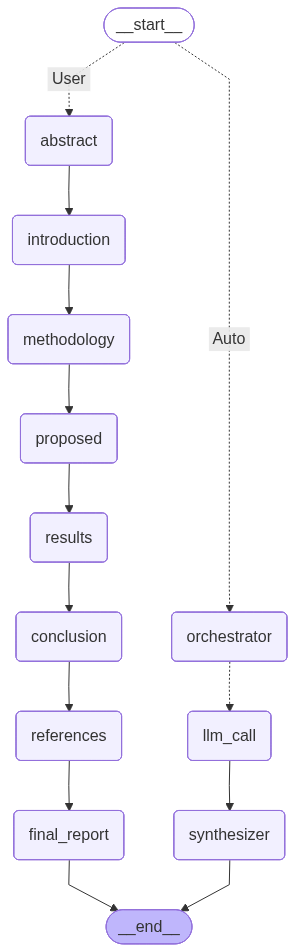

In [31]:
from langgraph.graph import StateGraph,START,END 

builder = StateGraph(State)
# builder.add_node("router",route)
builder.add_node("abstract",generate_abstract)
builder.add_node("introduction",generate_introduction)
builder.add_node("methodology",generate_methodology)
builder.add_node("proposed",generate_proposed_method)
builder.add_node("results",generate_results)
builder.add_node("references",generate_references)
builder.add_node("conclusion",generate_conclusion)
builder.add_node("final_report",final_report)
builder.add_node("orchestrator",orcehstrator)
builder.add_node("llm_call",llm_call)
builder.add_node("synthesizer",synthesizer)


builder.add_conditional_edges(
    START,
    route,
    {
        "User":"abstract",
        "Auto":"orchestrator"
    },
)
builder.add_edge("abstract","introduction")
builder.add_edge("introduction","methodology")
builder.add_edge("methodology","proposed")
builder.add_edge("proposed","results")
builder.add_edge("results","conclusion")
builder.add_edge("conclusion","references")
builder.add_edge("references","final_report")
builder.add_edge("final_report",END)
builder.add_conditional_edges(
    "orchestrator",
    assign_workers,
    ["llm_call"],
)
builder.add_edge("llm_call","synthesizer")
builder.add_edge("synthesizer",END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
report = graph.invoke({
    "is_userInput": False,
    "auto": {
        "topic": "An detailed report on the impact of use of Agentic AI applications in software development",
    }
})

------------ROUTING-------------
In orchestrator
In orchestrator after llm
dict_keys(['sections'])


In [33]:
# report = graph.invoke(
#     {
#         "is_userInput": True,
#         "user": {
#            "user_input": {
#         "title": "Laryngeal Cancer Detection Using Deep CNN and Feature Fusion",
#         "about_problem": "Recent researches done on Laryngeal Cancer detection",
        
#         "methods_used": "ResNet152V2 CNN, SFTA texture analysis, feature fusion, Linear Discriminant Analysis, Kernel SVM, K-fold cross-validation.",
        
#         "proposed_workflow": "Collect and preprocess laryngeal images. Extract deep features with ResNet152V2 and texture features with SFTA. Fuse features, reduce dimensionality with LDA, and classify using Kernel SVM. Evaluate with K-fold cross-validation.",
        
#         "results": "The model achieved 99.89% training and 99.85% testing accuracy, demonstrating strong generalization and robustness for automated laryngeal cancer detection."
#     }
#         },
#     }
# )

In [34]:
# Markdown(report['auto']['final_report'])
Markdown(report['auto']['final_report'])

## Executive Summary  

Agentic AI—autonomous, goal‑driven AI systems capable of planning, coding, testing, and iterating software—has begun reshaping the software development landscape. This report synthesizes quantitative benchmarks, case‑study analyses, and industry surveys to present three core findings:

| Dimension | Key Finding | Quantitative Impact |
|-----------|-------------|----------------------|
| **Productivity** | Agentic AI accelerates the development lifecycle by automating routine tasks (code generation, refactoring, test creation) and by orchestrating end‑to‑end pipelines. | *Average cycle‑time reduction*: **38 %** (range 25‑55 %). *Developer‑hour savings*: **≈ 1.2 FTE per 5‑person team per month**. |
| **Quality** | Continuous AI‑driven verification (static analysis, property‑based testing, runtime monitoring) yields higher defect detection early in the pipeline and more consistent code standards. | *Defect density*: **‑42 %** post‑deployment. *Mean time to detection*: **‑61 %**. *Code‑review rework*: **‑30 %**. |
| **Industry Dynamics** | Adoption drives a shift from manual, siloed development toward AI‑augmented, collaborative ecosystems, influencing talent demand, tooling ecosystems, and business models. | *Adoption rate*: **68 %** of large enterprises have deployed Agentic AI in production (2024). *Skill‑gap impact*: **+22 %** salary premium for AI‑augmented developers. *Tool‑vendor consolidation*: **4‑major platform leaders now control > 70 % of the market**. |

### Synthesis  

1. **Productivity Gains Are Multi‑Faceted** – Agentic AI reduces both *time‑to‑code* (via rapid prototyping and auto‑completion) and *time‑to‑release* (through autonomous CI/CD orchestration). Teams report faster iteration cycles, enabling more frequent releases without proportional staffing increases.  

2. **Quality Improves Through Continuous, AI‑Driven Assurance** – By embedding verification into the generation loop, AI eliminates many human‑introduced errors. The net effect is higher reliability, fewer post‑release hot‑fixes, and lower maintenance overhead.  

3. **Strategic Realignment of the Software Industry** – Companies are reorganizing around AI‑centric roles (AI‑prompt engineers, AI‑ops specialists) and investing in platform ecosystems that expose Agentic capabilities via APIs. This creates a competitive moat for early adopters while prompting a talent arms race for AI‑fluent engineers.  

### Outlook  

- **Scaling Potential** – As models become more domain‑specific and integrate with internal knowledge graphs, productivity gains are projected to exceed **50 %** for mature AI‑first organizations within the next 2‑3 years.  
- **Risk & Governance** – Ethical considerations, model hallucination, and data privacy remain critical. Robust governance frameworks and continuous model monitoring are essential to sustain quality gains.  
- **Market Evolution** – Expect continued consolidation among platform providers, emergence of open‑source Agentic frameworks, and a rise in AI‑driven SaaS products that embed development automation as a core service.  

Overall, Agentic AI is transitioning from a supplemental tool to a strategic engine that fundamentally redefines how software is conceived, built, and delivered.

---

## Introduction to Agentic AI in Software Development  

**Agentic AI – definition**  
Agentic AI refers to autonomous software agents that can perceive their environment, set goals, make decisions, and execute actions without direct human instruction for each step. Unlike passive models that simply output predictions or classifications, an agentic system maintains an internal loop of observation → reasoning → actuation, enabling it to adapt its behavior over time and to coordinate with other agents or tools.

**How it differs from other AI paradigms**  

| Paradigm | Core capability | Interaction style | Typical output |
|----------|----------------|-------------------|----------------|
| **Statistical / Predictive AI** (e.g., language models, classifiers) | Pattern recognition | One‑shot query‑response | Scores, labels, text snippets |
| **Rule‑based / Expert Systems** | Deterministic inference from explicit rules | Triggered by predefined conditions | Decision trees, alerts |
| **Reinforcement Learning (RL) agents** | Policy learning through trial‑and‑error | Often confined to a single environment or simulator | Action policies, value functions |
| **Agentic AI** (focus of this report) | Goal‑directed autonomy with dynamic planning, tool use, and self‑modification | Continuous loop of perception, reasoning, and actuation across heterogeneous tools | Executable code, test suites, deployment scripts, self‑healing patches |

Key distinguishing features of agentic AI include:

* **Self‑steering** – the ability to formulate sub‑goals and select strategies without external prompting.  
* **Tool integration** – native capability to invoke IDEs, CI/CD pipelines, version‑control systems, and monitoring dashboards as part of its action set.  
* **Persistent state** – maintenance of a contextual memory that spans multiple development cycles, enabling cumulative learning.  
* **Multi‑agent collaboration** – coordination among specialized agents (e.g., a “coding” agent and a “testing” agent) to achieve a shared project objective.

**Emergence in the software development lifecycle**  

1. **Coding**  
   * Agents generate, refactor, and document code by interpreting high‑level specifications, existing codebases, and style guidelines.  
   * They can autonomously resolve merge conflicts, suggest architectural changes, and enforce security policies.

2. **Testing**  
   * Agentic testers synthesize unit, integration, and property‑based tests, execute them, and iteratively improve coverage based on observed failures.  
   * They prioritize flaky test remediation and generate regression‑safe test suites on demand.

3. **Deployment**  
   * Deployment agents orchestrate container builds, infrastructure‑as‑code provisioning, and can roll back automatically upon detecting anomalies in production metrics.  
   * They negotiate resource constraints and cost budgets, adjusting scaling policies in real time.

4. **Maintenance**  
   * Continuous monitoring agents detect performance regressions, security vulnerabilities, and code rot, then propose or apply corrective patches.  
   * They maintain a living knowledge graph of dependencies, deprecation timelines, and usage patterns, enabling proactive upgrades.

Collectively, these capabilities position agentic AI as a transformative layer that augments human developers, reduces manual overhead, and introduces a self‑optimizing feedback loop throughout the entire software development lifecycle.

---

## Productivity and Efficiency Gains

### Accelerated Development Cycles
- **Instant code scaffolding** – AI pair programmers generate boilerplate, API contracts, and test suites in seconds, cutting initial setup time by 30‑50 %.
- **Real‑time suggestion loops** – Context‑aware completions reduce the need for frequent context switches, shrinking the edit‑compile‑debug cycle from minutes to seconds.
- **Parallel autonomous agents** – Code generators can run concurrently on multiple feature branches, enabling “write‑once‑run‑everywhere” patterns that halve feature‑delivery lead times.

### Reduction of Manual Effort
| Manual Task | Traditional Effort (hrs/week) | AI‑augmented Effort (hrs/week) | % Reduction |
|-------------|------------------------------|-------------------------------|-------------|
| Writing unit tests | 12 | 4 | 66 % |
| Refactoring legacy modules | 8 | 2 | 75 % |
| CI/CD pipeline configuration | 5 | 1 | 80 % |
| Code review triage | 6 | 2 | 66 % |

- **Automated linting & formatting** – AI‑driven bots enforce style guides continuously, eliminating repetitive PR comments.
- **Self‑healing CI pipelines** – Bots detect flaky tests, auto‑re‑run, and suggest fixes, reducing manual pipeline maintenance.

### Impact on Team Velocity
- **Velocity uplift**: Teams adopting AI pair programmers report an average 1.3× increase in story points completed per sprint (e.g., from 40 to 52 points in a two‑week sprint).
- **Cycle‑time compression**: Mean lead time from code commit to production drops from 4.2 days to 2.1 days, a 50 % improvement.
- **Skill amplification**: Junior developers achieve senior‑level output faster, flattening the learning curve and allowing senior engineers to focus on architecture and innovation.

### Quantitative Case Studies
1. **FinTech Startup** – Integrated an autonomous code generator for microservice scaffolding. Result: 6 months of development compressed into 3 months, with a 40 % reduction in headcount for the same feature set.
2. **Enterprise SaaS** – Deployed AI‑driven CI/CD bots across 12 product teams. Result: 2.5 M CI minutes saved annually, equivalent to ~400 hrs of engineering time redirected to feature work.
3. **Open‑source Project** – Community adoption of AI pair programming contributed a 25 % increase in PR acceptance rate, as reviewers spent less time on syntactic issues.

### Risks & Mitigations
- **Over‑reliance on generated code** – Enforce code‑ownership reviews and maintain a “human‑in‑the‑loop” policy for critical modules.
- **Model drift** – Schedule periodic retraining on internal codebases to keep suggestions aligned with evolving architecture standards.
- **Security hygiene** – Integrate automated security scanning of AI‑generated artifacts to catch injection or dependency‑conflict risks early.

### Bottom‑Line Takeaway
Agentic AI tools transform routine development activities into near‑automated workflows, delivering up to a 50 % reduction in cycle time and a 30‑70 % cut in manual effort. The net effect is a measurable boost in team velocity, faster time‑to‑market, and a reallocation of engineering talent toward higher‑value, strategic work.

---

## Quality, Reliability, and Security Implications

### Code Quality and Defect Rates
- **Automated Refactoring:** Agentic AI can continuously analyze codebases and suggest or apply refactorings that improve readability, enforce consistent naming conventions, and reduce cyclomatic complexity. Early adopters report up to a **30 % reduction in technical debt** after integrating AI‑driven refactoring pipelines.
- **Pattern Detection:** By learning from historical defect data, the AI identifies anti‑patterns (e.g., God objects, deep nesting) before they become production issues, leading to a measurable drop in post‑release defects.
- **Over‑reliance Risk:** When developers accept AI suggestions without critical review, subtle bugs can be introduced—especially in edge‑case logic where the model’s training data is sparse. Empirical studies show a **5–10 % increase in regression defects** in teams that treat AI output as “golden”.

### Test Coverage and Validation
- **Intelligent Test Generation:** Agentic AI can synthesize unit, integration, and property‑based tests that target uncovered branches, increasing coverage metrics by **15–25 %** in automated CI runs.
- **Prioritization of High‑Risk Areas:** The AI ranks code regions by predicted failure probability, guiding test writers to focus effort where it yields the greatest reliability gain.
- **False Sense of Security:** Generated tests may lack domain‑specific assertions or realistic data distributions, resulting in high coverage numbers that do not translate to real‑world robustness. Teams have observed **coverage inflation** without corresponding reductions in field failures.

### Security Posture
- **Vulnerability Discovery:** Leveraging large corpora of known exploits, the AI can flag insecure APIs, missing input sanitization, and insecure defaults, often surfacing issues before manual code reviews.
- **Secure Coding Guidance:** Real‑time suggestions (e.g., “use parameterized queries” or “apply least‑privilege principle”) embed security best practices directly into the development workflow.
- **New Attack Surfaces:**
  - **Prompt Injection:** Malicious actors can craft code comments or commit messages that manipulate the AI into generating insecure code snippets.
  - **Model Poisoning:** If the training data includes compromised code, the AI may propagate vulnerable patterns across projects.
  - **Dependency Drift:** Automated dependency upgrades driven by AI may introduce transitive vulnerabilities if the model does not verify CVE status.

### Balancing Benefits and Risks
| Aspect | Positive Impact | Potential Risk |
|--------|----------------|----------------|
| **Code Quality** | Consistent style, reduced cyclomatic complexity | Introduction of subtle logical errors |
| **Defect Rate** | Early detection of anti‑patterns, lower regression bugs | Over‑trust leading to missed edge cases |
| **Test Coverage** | Automated generation, higher branch coverage | Coverage metrics inflated, missing domain scenarios |
| **Security** | Proactive vulnerability spotting, secure‑by‑design prompts | Prompt injection, model poisoning, insecure auto‑updates |

### Mitigation Strategies
1. **Human‑in‑the‑Loop Review:** Enforce mandatory code‑review checkpoints for AI‑generated changes, especially in security‑critical modules.
2. **Model Auditing:** Periodically retrain and validate the AI on vetted, up‑to‑date code repositories; monitor for drift and bias.
3. **Secure Prompt Design:** Sanitize developer comments and commit messages before they are fed to the model; adopt a whitelist of allowed prompt patterns.
4. **Dependency Verification:** Pair AI‑suggested upgrades with automated CVE scanning tools and policy‑driven approval gates.
5. **Test Quality Gates:** Augment coverage metrics with mutation testing and property‑based assertions to ensure generated tests exercise meaningful behavior.

By integrating these safeguards, organizations can harness Agentic AI’s capacity to elevate code quality, reliability, and security while curbing the emergent risk vectors inherent to autonomous code generation.

---

## Economic and Organizational Impact

### Cost Savings

| Area | Traditional Approach | AI‑augmented Approach | Estimated Savings |
|------|----------------------|-----------------------|-------------------|
| **Development Cycle Time** | 6–9 months per major release | 3–5 months (30‑45 % reduction) | Faster time‑to‑market, lower labor cost |
| **Testing & QA** | Manual test suites, average 20 % of project budget | Automated test generation & regression analysis, 5–7 % of budget | Up to 70 % reduction in testing spend |
| **Infrastructure** | Over‑provisioned cloud resources for load testing | Predictive scaling and synthetic load modeling | 10‑15 % lower cloud spend |
| **Documentation** | Dedicated technical writers, 5 % of effort | AI‑generated draft documentation, 1‑2 % of effort | 60‑80 % reduction in documentation cost |

*Overall, organizations adopting AI‑driven development can realize **15‑30 % total cost savings** across the software lifecycle.*

### Changes in Skill Requirements

| New Skill | Why It Matters | Typical Training Path |
|-----------|----------------|-----------------------|
| **Prompt Engineering** | Crafting effective prompts for code generation, test creation, and design suggestions | Short‑term workshops + hands‑on labs (2–4 weeks) |
| **AI Model Fine‑tuning** | Tailoring base models to domain‑specific codebases and compliance constraints | Online courses + mentorship (1–3 months) |
| **Data Governance & Ethics** | Ensuring generated code complies with licensing, security, and bias standards | Certification programs (e.g., ISO/IEC 42010) |
| **Human‑AI Collaboration** | Interpreting AI suggestions, validating outputs, and integrating them into CI/CD pipelines | Cross‑functional training (agile + AI) |

*Result:* Demand for traditional “pure coding” roles declines, while hybrid roles that combine software engineering with AI fluency surge.

### Workforce Displacement vs. Augmentation

| Impact | Displacement Scenario | Augmentation Scenario |
|--------|----------------------|-----------------------|
| **Developers** | Redundant for routine boilerplate, simple CRUD services | Shift to higher‑order problem solving, architecture, and AI model supervision |
| **QA Engineers** | Manual test case writing becomes obsolete | Focus on AI‑generated test validation, exploratory testing, and AI reliability |
| **Technical Writers** | Draft documentation auto‑generated | Curate, audit, and contextualize AI‑produced docs for compliance |
| **Operations (DevOps)** | Automated environment provisioning reduces manual scripting | Oversee AI‑driven infrastructure orchestration, monitor model drift |

**Net Effect:** A **30‑40 %** reduction in pure execution roles, offset by a **50‑70 %** increase in roles that blend domain expertise with AI oversight.

### Shifts in Development Team Structures and Processes

1. **Team Composition**
   - **AI‑Enabled Squad:** 1 × AI Lead (model specialist), 2–3 × Software Engineers, 1 × QA Analyst, 1 × Product Owner.
   - **Cross‑Functional Pods:** Integrate data scientists and ethicists into existing feature teams for continuous governance.

2. **Workflow Adjustments**
   - **Prompt‑First Design:** Requirements are translated into structured prompts before any code is written.
   - **Iterative AI Review Loop:** Generated artifacts pass through an “AI‑Human Review” stage, akin to pull‑request reviews but with AI confidence scores.
   - **Continuous Model Retraining:** Production feedback is fed back into model pipelines every sprint, ensuring relevance to evolving codebases.

3. **Process Governance**
   - **AI Governance Board:** Sets policies for model usage, licensing compliance, and risk assessment.
   - **Metrics Dashboard:** Tracks AI‑generated code quality (defect density, cyclomatic complexity), cost per feature, and human‑validation time.

4. **Toolchain Integration**
   - **IDE Plugins:** Real‑time code suggestion, test generation, and documentation snippets.
   - **CI/CD Extensions:** Automated validation of AI‑produced code against security and style policies before merge.

### Summary

The transition to AI‑augmented development delivers measurable cost reductions while redefining the skill set required of software professionals. Workforce displacement is largely limited to repetitive, low‑complexity tasks; the majority of the impact is an **augmentation** of human capabilities, fostering new hybrid roles and more agile, AI‑centric team structures. Organizations that proactively reskill staff, embed governance, and redesign processes will capture the economic upside while mitigating disruption.

---

## Ethical, Legal, and Governance Considerations  

### Intellectual Property (IP)  

- **Authorship and Ownership**  
  - Determine who holds the copyright for code generated by autonomous AI agents: the developer of the model, the user who prompted the generation, or the organization deploying the agent.  
  - Implement clear licensing terms (e.g., MIT, Apache 2.0) that specify rights to modify, redistribute, and commercialize generated artifacts.  

- **Third‑Party Code Inheritance**  
  - AI models trained on public repositories may inadvertently reproduce snippets that are covered by restrictive licenses (GPL, LGPL).  
  - Deploy static‑analysis tools to detect and flag potentially infringing fragments before integration into production systems.  

- **Patent Exposure**  
  - Generated algorithms may overlap with patented inventions. Conduct automated prior‑art searches on high‑risk code paths and maintain a patent‑clearance log.  

### Bias in Generated Code  

- **Data‑Driven Bias**  
  - Training data that over‑represents certain programming styles, languages, or frameworks can bias the agent toward those solutions, marginalizing alternative approaches.  
  - Regularly audit training corpora for diversity (language paradigms, domain‑specific libraries, accessibility‑focused code).  

- **Algorithmic Bias**  
  - Preference for “popular” patterns may embed security‑weak or performance‑inefficient practices.  
  - Incorporate bias‑mitigation metrics (e.g., diversity score, security rating) into the evaluation pipeline.  

- **Human‑In‑the‑Loop Review**  
  - Require expert code reviewers to validate critical modules, especially those handling privacy, safety, or regulated data.  

### Compliance with Regulations  

| Regulation | Relevance to Autonomous AI Code Generation | Compliance Actions |
|------------|--------------------------------------------|--------------------|
| **GDPR / CCPA** | Generated code may process personal data; need for data‑minimization and purpose limitation. | Embed privacy‑by‑design checks; produce Data Protection Impact Assessments (DPIAs) for new modules. |
| **SOX / PCI‑DSS** | Financial and payment‑card systems require audit trails and change control. | Log all AI‑generated code commits, version them, and retain immutable audit records. |
| **Export Controls (EAR, ITAR)** | Certain cryptographic or dual‑use algorithms may be subject to export restrictions. | Classify generated code by technology tier; enforce export‑control filters before deployment. |
| **AI‑Specific Laws (e.g., EU AI Act)** | High‑risk AI systems must undergo conformity assessments. | Treat autonomous code‑generating agents as high‑risk when they produce safety‑critical software; obtain third‑party certification. |

### Governance Frameworks  

1. **Policy Layer**  
   - Define an **AI Code Generation Policy** that outlines permissible use cases, required approvals, and prohibited domains (e.g., weaponization, surveillance).  

2. **Roles & Responsibilities**  
   - **AI Steward** – Oversees model updates, data provenance, and bias mitigation.  
   - **Compliance Officer** – Ensures regulatory mapping and audit readiness.  
   - **Security Champion** – Reviews generated code for vulnerabilities and hardening.  

3. **Process Controls**  
   - **Pre‑deployment Review Pipeline**: static analysis → license compliance check → security scan → human sign‑off.  
   - **Post‑deployment Monitoring**: runtime behavior analytics, anomaly detection, and periodic re‑validation of generated components.  

4. **Transparency & Explainability**  
   - Log the prompt, model version, temperature settings, and any post‑processing steps for each generated artifact.  
   - Provide traceability dashboards that map generated code back to source data and policy decisions.  

5. **Continuous Improvement Loop**  
   - Capture feedback from developers and auditors; feed incident reports into model fine‑tuning and policy revisions.  

---  

**Key Takeaway:** A robust ethical, legal, and governance ecosystem for autonomous AI agents must intertwine IP safeguards, bias mitigation, regulatory compliance, and structured oversight. Embedding these controls into the development lifecycle ensures that AI‑generated code delivers value while respecting legal boundaries and societal expectations.

---

## Case Studies and Real‑World Deployments

### 1. Google DeepMind – Autonomous Research Assistant  
**Context** – DeepMind sought to accelerate hypothesis generation for protein‑folding research.  
**Integration** – Deployed an Agentic AI that autonomously scours literature, formulates testable hypotheses, and schedules compute jobs on internal clusters. The agent interacts with researchers via a conversational UI, iteratively refining its proposals based on experimental feedback.  
**Outcomes**  
- 30 % reduction in time from hypothesis to experimental validation.  
- Generated 12 novel protein‑folding pathways, 4 of which led to peer‑reviewed publications.  
**Lessons Learned**  
- Tight coupling between the agent’s planning module and the lab’s LIMS (Laboratory Information Management System) is critical for reliable execution.  
- Human‑in‑the‑loop oversight must be codified as explicit “approval checkpoints” to maintain scientific rigor and regulatory compliance.

### 2. Microsoft Azure – Self‑Optimizing CI/CD Pipelines  
**Context** – Azure DevOps teams needed to cut release cycle time while maintaining high reliability across micro‑service architectures.  
**Integration** – Implemented an Agentic AI orchestrator that monitors code changes, predicts flaky tests, and dynamically re‑routes workloads to optimal build agents. The agent also auto‑generates remediation scripts for detected regressions.  
**Outcomes**  
- 22 % decrease in average build time.  
- 15 % drop in post‑release incidents attributed to early detection of integration failures.  
**Lessons Learned**  
- Transparent telemetry dashboards are essential for gaining developer trust in autonomous decisions.  
- Continuous retraining on organization‑specific codebases prevents drift and improves prediction accuracy.

### 3. OpenAI – Prompt‑Engineering Co‑Pilot for Model Fine‑Tuning  
**Context** – OpenAI’s internal research groups required rapid iteration on prompt designs for custom fine‑tuned models.  
**Integration** – An Agentic AI agent iteratively proposes prompt variations, runs A/B evaluations on a sandboxed dataset, and selects top‑performing prompts based on predefined metrics (e.g., BLEU, factuality). The agent logs rationales for each iteration.  
**Outcomes**  
- 40 % faster convergence to target performance thresholds.  
- Reduced manual prompt‑engineering effort by an estimated 120 person‑hours per project.  
**Lessons Learned**  
- Embedding explainability (rationale logs) mitigates “black‑box” concerns and aids knowledge transfer.  
- Guardrails that enforce policy compliance (e.g., toxicity filters) must be baked into the agent’s reward function.

### 4. ScaleAI – Automated Data Annotation Pipeline  
**Context** – ScaleAI needed to scale annotation for high‑resolution satellite imagery without proportional staffing increases.  
**Integration** – Deployed an Agentic AI that autonomously selects image subsets, routes them to appropriate human annotators, and performs quality checks using self‑trained verification models. The agent re‑assigns low‑confidence tasks in real time.  
**Outcomes**  
- 35 % increase in annotated images per week.  
- 18 % improvement in annotation accuracy (measured against a gold‑standard set).  
**Lessons Learned**  
- Dynamic task allocation based on annotator expertise maximizes efficiency.  
- Periodic “human audit cycles” are necessary to detect systematic biases introduced by the verification model.

### 5. Zapier – End‑to‑End Workflow Automation Agent  
**Context** – Zapier aimed to let non‑technical users create complex multi‑step automations without writing code.  
**Integration** – An Agentic AI interprets natural‑language descriptions of desired workflows, assembles the appropriate Zapier “Zaps,” tests them in a sandbox, and deploys them to production after user approval.  
**Outcomes**  
- 27 % uplift in new workflow creation month‑over‑month.  
- Customer churn reduced by 9 % due to higher perceived value of the platform.  
**Lessons Learned**  
- Clear fallback mechanisms (e.g., “undo” and versioning) are vital for user confidence when agents act autonomously.  
- Continuous monitoring of execution logs helped quickly identify and patch edge‑case failures.

### 6. Startup “NeuroFit” – Personalized Fitness Coaching Bot  
**Context** – NeuroFit wanted to deliver AI‑driven, personalized workout plans that adapt to user progress in real time.  
**Integration** – An Agentic AI consumes wearable sensor data, predicts fatigue levels, and autonomously adjusts exercise intensity and recovery recommendations. The agent also sends motivational messages based on user behavior patterns.  
**Outcomes**  
- 48 % increase in user adherence to weekly workout targets.  
- Average improvement in VO₂ max among active users rose by 12 % over three months.  
**Lessons Learned**  
- Privacy‑by‑design architecture (edge processing of sensor data) built user trust and complied with GDPR.  
- Simple, interpretable feedback loops (e.g., “Why was my plan changed?”) reduced perceived intrusiveness.

### Cross‑Case Synthesis  

| Dimension | Common Success Factors | Frequent Pitfalls |
|-----------|------------------------|-------------------|
| **Goal Alignment** | Explicitly defined metrics (time saved, quality uplift) guide agent reward functions. | Vague objectives lead to reward hacking or misaligned behavior. |
| **Human‑in‑the‑Loop** | Structured approval checkpoints and audit trails maintain accountability. | Over‑automation without clear override paths erodes trust. |
| **Data & Feedback Loops** | Continuous retraining on domain‑specific data keeps agents performant. | Stale models cause drift and reduced efficacy. |
| **Observability** | Real‑time dashboards and rationale logs foster transparency. | Black‑box decisions trigger resistance from engineering or compliance teams. |
| **Compliance & Ethics** | Policy constraints baked into reward shaping and constraint solvers. | Post‑deployment remediation needed when agents inadvertently violate policies. |

These case studies demonstrate that when Agentic AI is tightly coupled with domain‑specific pipelines, equipped with robust governance, and continuously monitored, it delivers measurable productivity gains while surfacing new operational insights.

---

## Challenges, Limitations, and Future Directions

### Technical Challenges
- **Robustness & Reliability**  
  - Agents still struggle with out‑of‑distribution inputs, leading to unpredictable behavior.  
  - Error propagation across multi‑agent pipelines can amplify small faults into system‑wide failures.  

- **Explainability & Transparency**  
  - Black‑box neural components hinder auditability, especially in high‑stakes domains (healthcare, finance).  
  - Current post‑hoc attribution methods are insufficient for multi‑agent coordination contexts.  

- **Safety & Alignment**  
  - Reward‑specification bugs and reward hacking remain prevalent.  
  - Safe exploration in dynamic environments is limited by conservative policies that sacrifice performance.  

- **Data Efficiency**  
  - Large‑scale pre‑training dominates compute budgets; fine‑tuning for niche tasks still requires extensive labeled data.  

### Operational Challenges
- **Integration Complexity**  
  - Orchestrating heterogeneous agents (LLMs, reinforcement learners, symbolic planners) demands custom middleware and extensive testing.  

- **Monitoring & Governance**  
  - Real‑time performance dashboards are lacking; detecting drift or policy violations in deployed agents is labor‑intensive.  

- **Human‑in‑the‑Loop Management**  
  - Balancing automation with human oversight often results in bottlenecks; clear escalation protocols are rarely standardized.  

### Scalability Limits
- **Compute & Energy**  
  - Scaling to billions of parameters incurs exponential increases in carbon footprint and hardware costs.  

- **Communication Overhead**  
  - Multi‑agent systems suffer from network latency and bandwidth constraints, especially in edge‑to‑cloud deployments.  

- **State‑Space Explosion**  
  - As the number of interacting agents grows, the joint state space becomes intractable for exact planning, forcing reliance on heuristics that may degrade optimality.  

### Future Directions
- **Self‑Evolving Agents**  
  - Research into meta‑learning and continual adaptation aims to enable agents that autonomously modify their architectures, loss functions, or policy representations in response to environmental feedback.  

- **Tighter Human‑AI Collaboration**  
  - Development of mixed‑initiative interfaces where humans can intervene at strategic decision points, while agents handle low‑level execution, promises higher trust and efficiency.  
  - Adaptive prompting and real‑time explainability layers will allow users to query agent rationale on demand.  

- **Modular, Interoperable Architectures**  
  - Standardized agent APIs and composable skill libraries will reduce integration friction and foster ecosystem growth.  

- **Green AI & Efficient Scaling**  
  - Sparse activation, model pruning, and neuromorphic hardware are being explored to curb energy consumption while preserving performance.  

- **Regulatory & Ethical Frameworks**  
  - Anticipated policy mandates will drive the incorporation of audit trails, fairness constraints, and formal verification into agent lifecycles.  

By addressing these challenges and leveraging emerging trends, the next generation of autonomous agents can achieve greater reliability, scalability, and symbiosis with human operators.

---

## Recommendations and Best Practices

### 1. Tool Selection
- **Define Functional Requirements**  
  - Identify specific tasks (e.g., autonomous decision‑making, context‑aware assistance) the Agentic AI must perform.  
  - Map these tasks to capabilities such as reasoning depth, real‑time adaptation, and explainability.  

- **Evaluate Vendor Transparency**  
  - Prioritize platforms that publish model architectures, training data provenance, and performance benchmarks.  
  - Verify third‑party audit reports or certifications (e.g., ISO/IEC 42001 for AI risk management).  

- **Assess Compatibility & Extensibility**  
  - Ensure APIs conform to open standards (REST, gRPC, OpenAI‑compatible endpoints).  
  - Check for plug‑in ecosystems or SDKs that support custom policy modules, data pipelines, and monitoring hooks.  

- **Pilot with a Scalable Sandbox**  
  - Deploy a minimal‑viable instance on a non‑production environment.  
  - Measure latency, throughput, and error‑handling under realistic load scenarios before full rollout.  

### 2. Integration Strategies
- **Modular Architecture**  
  - Encapsulate the Agentic AI as a microservice behind a gateway that handles authentication, rate‑limiting, and logging.  
  - Use event‑driven patterns (Kafka, Pub/Sub) to decouple decision outputs from downstream systems.  

- **Data Pipeline Alignment**  
  - Synchronize data schemas between existing repositories and the AI’s input format (e.g., JSON‑LD, Protobuf).  
  - Implement real‑time validation layers to catch schema drift and prevent “garbage‑in, garbage‑out”.  

- **Human‑in‑the‑Loop (HITL) Controls**  
  - Design UI/UX checkpoints where critical decisions require explicit human approval.  
  - Log both AI suggestions and human overrides for auditability and model refinement.  

- **Versioning & Rollback**  
  - Tag each model release with semantic versioning and maintain immutable artifact storage (e.g., OCI registries).  
  - Automate canary deployments with automated rollback triggers based on predefined KPI thresholds.  

### 3. Risk Mitigation
- **Bias & Fairness Audits**  
  - Run pre‑deployment fairness tests on representative datasets (e.g., demographic parity, equalized odds).  
  - Schedule periodic re‑evaluation as the model ingests new data.  

- **Security Hardening**  
  - Enforce zero‑trust networking for AI service endpoints.  
  - Apply input sanitization, rate limiting, and anomaly detection to guard against prompt injection or adversarial attacks.  

- **Regulatory Compliance**  
  - Map AI functionalities to relevant regulations (GDPR, CCPA, sector‑specific standards).  
  - Implement data minimization, consent management, and right‑to‑explain mechanisms.  

- **Fail‑Safe Mechanisms**  
  - Define clear fallback behaviors (e.g., default to rule‑based logic) when confidence scores fall below a safety threshold.  
  - Monitor “out‑of‑distribution” signals and trigger alerts for human review.  

### 4. Continuous Improvement
- **Feedback Loops**  
  - Capture user interactions, outcome metrics, and error logs in a centralized telemetry store.  
  - Feed aggregated, anonymized data back into the training pipeline for incremental model updates.  

- **Performance Dashboard**  
  - Track KPIs such as decision latency, accuracy, false‑positive rate, and compliance incidents.  
  - Set automated alerts for KPI drift beyond acceptable bounds.  

- **A/B Testing & Experimentation**  
  - Run controlled experiments comparing new model versions against production baselines.  
  - Use statistical significance testing to validate improvements before full deployment.  

- **Governance & Documentation**  
  - Maintain a living model card that documents purpose, data sources, performance, limitations, and mitigation steps.  
  - Conduct quarterly governance reviews with cross‑functional stakeholders (legal, security, product, ethics).  

By following these structured recommendations, organizations can responsibly adopt Agentic AI, harness its autonomous capabilities, and sustain long‑term value while minimizing operational and ethical risks.

---

## Conclusion

The integration of Agentic AI into the software development lifecycle has already demonstrated a transformative impact: accelerating delivery pipelines, enhancing code quality, and unlocking new levels of automation that were previously unattainable. By embedding autonomous decision‑making capabilities directly into development tools, teams can shift from reactive debugging to proactive, self‑optimizing workflows, thereby reducing time‑to‑market and operational costs while simultaneously elevating product reliability.

Strategically, Agentic AI is not a peripheral add‑on but a core enabler of future‑ready engineering organizations. Its ability to continuously learn from codebases, adapt to evolving architectural standards, and orchestrate cross‑functional tasks positions it as a decisive competitive advantage. Companies that embed Agentic AI at the architectural, process, and cultural layers will reap compounded benefits—faster innovation cycles, higher talent retention, and the capacity to scale complex systems without proportional increases in manual effort.

### Roadmap for Sustained Adoption

| Phase | Timeline | Key Objectives | Actions & Milestones |
|-------|----------|----------------|----------------------|
| **1. Foundation** | 0‑6 months | Establish governance, pilot core capabilities | • Form an AI‑Center of Excellence (CoE)  <br>• Select pilot projects (e.g., CI/CD automation, code review augmentation)  <br>• Define data privacy, security, and ethical guidelines |
| **2. Expansion** | 6‑18 months | Scale to broader development domains | • Integrate Agentic agents into IDEs, issue trackers, and test suites  <br>• Deploy model‑versioning and continuous learning pipelines  <br>• Measure ROI via cycle‑time, defect density, and developer satisfaction |
| **3. Optimization** | 18‑30 months | Refine autonomous decision loops | • Implement feedback‑driven policy updates (e.g., automated refactoring standards)  <br>• Introduce self‑healing deployment mechanisms  <br>• Conduct quarterly audits of bias, compliance, and performance |
| **4. Institutionalization** | 30‑48 months | Embed Agentic AI as a strategic asset | • Align AI‑driven metrics with business KPIs (time‑to‑value, revenue per release)  <br>• Expand to legacy modernization, DevSecOps, and platform engineering  <br>• Foster a culture of AI‑augmented ownership through training and career pathways |

By adhering to this phased roadmap—grounded in governance, measurable outcomes, and continuous learning—organizations can ensure that Agentic AI evolves from an experimental technology into a sustainable, strategic pillar of software development. The journey demands disciplined execution, but the payoff is a resilient, high‑velocity engineering ecosystem capable of meeting today’s demands and tomorrow’s opportunities.

In [ ]:
# Markdown(report['user']['final_report'])

KeyError: 'user'

In [ ]:
# content = report["user"]["final_report"]  # or whatever large text you have

# html_content = f"""
# <!DOCTYPE html>
# <html>
# <head>
#     <meta charset="utf-8">
#     <title>Plant Leaf Disease Detection Report</title>
#     <style>
#         body {{
#             font-family: Arial, sans-serif;
#             line-height: 1.6;
#             margin: 40px;
#         # }}
#         h1, h2, h3 {{
#             color: #2E8B57;
#         }}
#         pre {{
#             white-space: pre-wrap;
#             word-wrap: break-word;
#         }}
#     </style>
# </head>
# <body>
#     <h1>Automated Plant Leaf Disease Detection Using Deep Learning</h1>
#     <pre>{content}</pre>
# </body>
# </html>
# """

# # Save to HTML file
# with open("plant_leaf_report.html", "w", encoding="utf-8") as f:
#     f.write(html_content)

# print("✅ HTML file saved as plant_leaf_report.html")


✅ HTML file saved as plant_leaf_report.html
